<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import Residual_blocks as resblock
import Bottleneck_residual_blocks as bresblock
import history as hist

fatal: destination path 'AE-w.-Bottleneck-Residual-Blocks' already exists and is not an empty directory.
/content/AE-w.-Bottleneck-Residual-Blocks


In [3]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 256
batch_size = 128

initializer = initializers.HeNormal(seed=123)
#initializer = initializers.GlorotUniform()

In [4]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

In [5]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

# x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min', use_bn = 'False')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

# x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min', use_bn = 'False')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 bridge_residual_conv2d_blo  (None, 14, 14, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                           

In [20]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

#x = resblock.bridge_residual_conv2Dtrans_block(128, 1, 1, initializer)(x)

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

#x = resblock.bridge_residual_conv2Dtrans_block(128, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

#x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min', padding='same')(x)

#x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(x)

#x = resblock.bridge_residual_conv2D_block(32, 1, 3, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 re_lu_26 (ReLU)             (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 768)               393984    
                                                                 
 re_lu_27 (ReLU)             (None, 768)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              787456    
                                                                 
 re_lu_28 (ReLU)             (None, 1024)              0   

In [21]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 256)               13847104  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         17307139  
                                                                 
Total params: 31154243 (118.84 MB)
Trainable params: 31133251 (118.76 MB)
Non-trainable params: 20992 (82.00 KB)
_________________________________________________________________


In [22]:
K.clear_session()

In [23]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=2000, decay_rate=0.7)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=10)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse')
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=75, callbacks=[callback])

Epoch 1/75
391/391 [==============================] - 75s 129ms/step - loss: 0.0207 - val_loss: 0.0270
Epoch 2/75
391/391 [==============================] - 48s 124ms/step - loss: 0.0144 - val_loss: 0.0184
Epoch 3/75
391/391 [==============================] - 49s 124ms/step - loss: 0.0135 - val_loss: 0.0160
Epoch 4/75
391/391 [==============================] - 48s 124ms/step - loss: 0.0130 - val_loss: 0.0152
Epoch 5/75
391/391 [==============================] - 48s 124ms/step - loss: 0.0126 - val_loss: 0.0146
Epoch 6/75
391/391 [==============================] - 48s 124ms/step - loss: 0.0123 - val_loss: 0.0158
Epoch 7/75
391/391 [==============================] - 48s 124ms/step - loss: 0.0120 - val_loss: 0.0157
Epoch 8/75
391/391 [==============================] - 48s 124ms/step - loss: 0.0117 - val_loss: 0.0138
Epoch 9/75
391/391 [==============================] - 48s 124ms/step - loss: 0.0116 - val_loss: 0.0139
Epoch 10/75
391/391 [==============================] - 48s 124ms/step - l

In [24]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=8, verbose=1, start_from_epoch=5)
optim = keras.optimizers.Adam(learning_rate = 0.00001)
AE.compile(optimizer=optim,loss='mse')
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, callbacks=[callback])

Epoch 1/30
391/391 [==============================] - 75s 129ms/step - loss: 0.0061 - val_loss: 0.0083
Epoch 2/30
391/391 [==============================] - 49s 124ms/step - loss: 0.0060 - val_loss: 0.0083
Epoch 3/30
391/391 [==============================] - 49s 124ms/step - loss: 0.0060 - val_loss: 0.0083
Epoch 4/30
391/391 [==============================] - 49s 124ms/step - loss: 0.0060 - val_loss: 0.0084
Epoch 5/30
391/391 [==============================] - 49s 124ms/step - loss: 0.0060 - val_loss: 0.0084
Epoch 6/30
391/391 [==============================] - 49s 124ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 7/30
391/391 [==============================] - 49s 125ms/step - loss: 0.0059 - val_loss: 0.0085
Epoch 8/30
391/391 [==============================] - 49s 125ms/step - loss: 0.0059 - val_loss: 0.0085
Epoch 9/30
391/391 [==============================] - 49s 125ms/step - loss: 0.0059 - val_loss: 0.0084
Epoch 10/30
391/391 [==============================] - 49s 125ms/step - l

In [25]:
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = 0.000001)
AE.compile(optimizer=optim,loss='mse')
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15)

Epoch 1/15
391/391 [==============================] - 75s 129ms/step - loss: 0.0057 - val_loss: 0.0084
Epoch 2/15
391/391 [==============================] - 49s 125ms/step - loss: 0.0056 - val_loss: 0.0084
Epoch 3/15
391/391 [==============================] - 49s 125ms/step - loss: 0.0056 - val_loss: 0.0084
Epoch 4/15
391/391 [==============================] - 49s 124ms/step - loss: 0.0056 - val_loss: 0.0085
Epoch 5/15
391/391 [==============================] - 49s 124ms/step - loss: 0.0056 - val_loss: 0.0084
Epoch 6/15
391/391 [==============================] - 48s 124ms/step - loss: 0.0056 - val_loss: 0.0084
Epoch 7/15
391/391 [==============================] - 49s 124ms/step - loss: 0.0056 - val_loss: 0.0084
Epoch 8/15
391/391 [==============================] - 48s 124ms/step - loss: 0.0056 - val_loss: 0.0084
Epoch 9/15
391/391 [==============================] - 49s 124ms/step - loss: 0.0056 - val_loss: 0.0084
Epoch 10/15
391/391 [==============================] - 49s 124ms/step - l

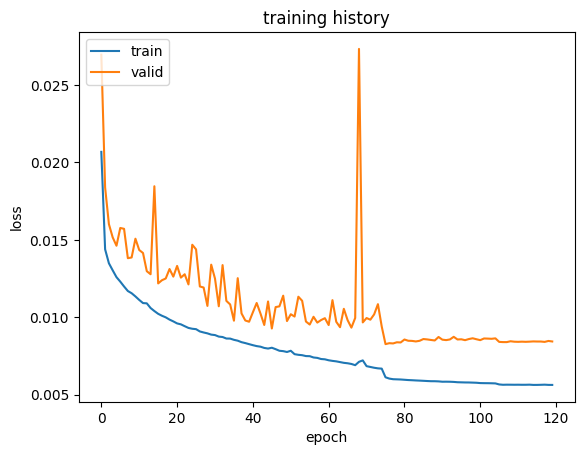

In [27]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss'])

plt.title('training history')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.show()

In [28]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim =' + str(latent_dim), fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

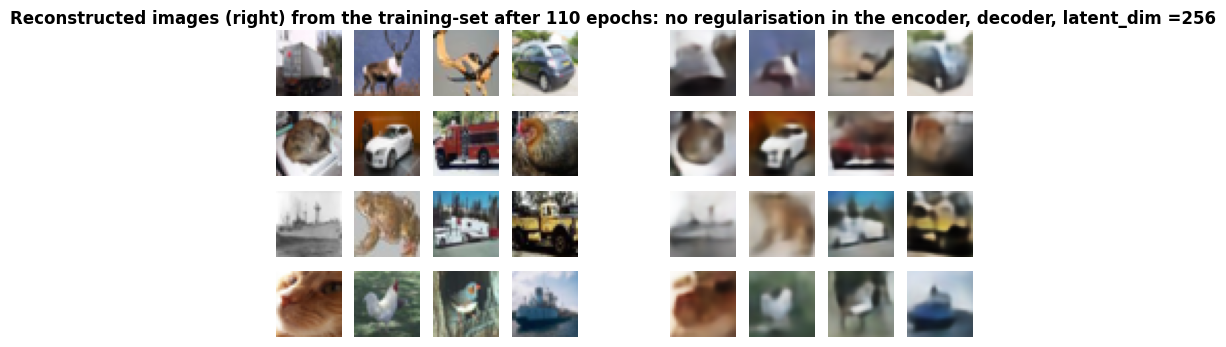

In [30]:
plot_reconstruction(img_train, 'training', 123, 110)

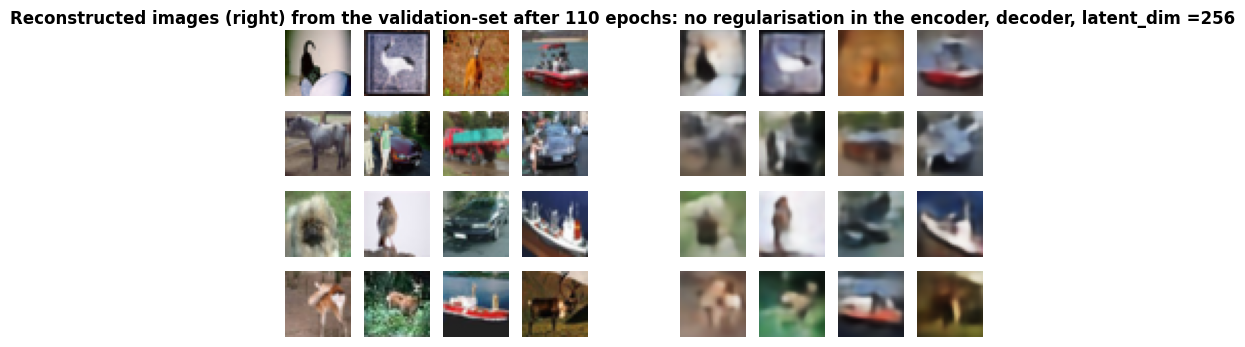

In [31]:
plot_reconstruction(img_valid, 'validation', 123, 110)

This is the best training set performance obtained, so the model has converged better, but it's not the best validation set performance, so it has done worse in terms of generalisation.

It does not make sense to use residual blocks for the one layer deep unit kernel convolutions, so we'll replace them with plain conv or conv trans layers and see